In [1]:
from model.types import MarketDemandSupply
from model.run import load_config, run, post_processing
import matplotlib.pyplot as plt
from model.mechanism.amm_k import amm_k_mechanism
from model.mechanism.treasury import liq_backing_mechanism,treasury_stables_mechanism,floating_supply_mechanism,liq_ohm_mechanism
from model.policy.rbs_price import lower_target_policy,upper_target_policy

params = {"demand_factor": [10],
         "supply_factor": [10],
         "initial_reserves_volatile":[17000000], # setting it as constant since in this simulation we don't use it at all.
         "reward_rate":[0.000198], # flat reward rate; (1 + r) ^ 365 ~ 7.5%
         "max_liq_ratio":[0.14375],  # LiquidityUSD : reservesUSD ratio --> 1:1 = 0.5
         "target_ma":[30], # number of days
         "lower_wall":[0.15],
         "upper_wall":[0.15],
         "lower_cushion":[.075],
         "upper_cushion":[.075],
          "reinstate_window": [30],
          "max_outflow_rate": [0.05]
         }


initialstate = { # variable values borrowed from liquidity-olympus/simulation.ipynb
            'supply':30000000,
            "liq_stables": 21000000,
            "reserves_stables":200000000,
            "reserves_volatile":17000000,
            "price":9,

            "market_demand_supply": MarketDemandSupply(total_supply = 50,
                                                   total_demand = 50),
                                                   
            # treasury policy
            'target_liq_ratio_reached':False,
            'reserves_in':0,
            'supply':25000000,

            # RBS related
            'ma_target':9,
            # market transaction variables
            'ask_change_ohm':0,
            'bid_change_ohm':0,
            "net_flow": None
            }
# initialize parameters that are decided by other parameters
initialstate['amm_k'] = amm_k_mechanism(initialstate)
initialstate['price_history']=[initialstate['price']]

initialstate['lb_target'] = initialstate['ma_target']
initialstate['price_target']=initialstate['ma_target']

initialstate['liq_ohm'] = liq_ohm_mechanism(initialstate['liq_stables'],initialstate['price'])
initialstate['floating_supply'] = floating_supply_mechanism(initialstate['supply'],initialstate['liq_ohm'])



initialstate['treasury_stables'] = treasury_stables_mechanism(initialstate['liq_stables'],initialstate['reserves_stables'])
initialstate['liq_backing'] = liq_backing_mechanism(initialstate['treasury_stables'],params['initial_reserves_volatile'][0])
initialstate['target_walls'] = [lower_target_policy(initialstate['price_target'], params['lower_wall'][0]),
                                upper_target_policy(initialstate['price_target'], params['upper_wall'][0])]
initialstate['target_cushions'] = [lower_target_policy(initialstate['price_target'], params['lower_cushion'][0]),
                                    upper_target_policy(initialstate['price_target'], params['upper_cushion'][0])]
initialstate['bid_counter'],initialstate['ask_counter'] = [0] * params["reinstate_window"][0],[0]* params["reinstate_window"][0]

nrun = 5
nstep = 10
exp = load_config(nrun, params, initialstate, nstep)
raw = run(exp)
df = post_processing(raw)


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.4.28
Execution Mode: local_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 10, 12, 5, 24)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (10, 12, 5, 24)
Execution Method: local_simulations
Execution Mode: parallelized
Total execution time: 0.49s


In [2]:
left = raw[raw["substep"] == 1][['liq_stables', 'reserves_stables']].sum(axis=1)
right = raw[raw["substep"] == 1]['treasury_stables']

assert (left == right).all()

In [3]:
left = raw[raw["substep"] == 2][['liq_stables', 'reserves_stables', 'reserves_volatile']].sum(axis=1)
right = raw[raw["substep"] == 2]['liq_backing']

assert (left == right).all()

In [4]:
left = raw[raw["substep"] == 3]['price_history'].apply(lambda x: len(x))
right = raw[raw["substep"] == 3]['timestep'] + 1

assert (left == right).all()

In [5]:
sample = raw[raw["substep"] == 4]

# Check length
assert (sample['bid_counter'].apply(lambda x: len(x)) == 30).all()

# Check last value
left = sample['bid_counter'].apply(lambda x: x[-1])
right = sample["price"] > sample['ma_target']

assert (left == right).all()

In [7]:
sample = raw[raw["substep"] == 5]

# Check length
assert (sample['ask_counter'].apply(lambda x: len(x)) == 30).all()

# Check last value
left = sample['ask_counter'].apply(lambda x: x[-1])
right = sample["price"] < sample['price_target']

assert (left == right).all()

Skipping check on 6 for now because I think there is an implementation question on whether this is the best way to calculate the moving average.

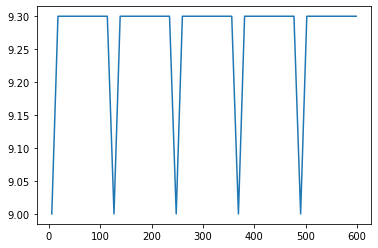

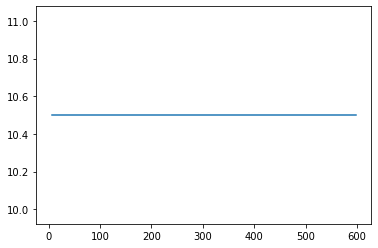

In [8]:
sample = raw[raw["substep"] == 6]
sample['ma_target'].plot(kind='line')
plt.show()
sample['lb_target'].plot(kind='line')
plt.show()

In [9]:
sample = raw[raw["substep"] == 7]

left = sample[["lb_target", "ma_target"]].apply(lambda x: max(x), axis=1)
right = sample["price_target"]

assert (left == right).all()

In [10]:
from math import isclose
sample = raw[raw["substep"] == 8]

left = sample.apply(lambda x: [(1 - params["lower_wall"][0]) * x["price_target"],
(1 + params["upper_wall"][0]) * x["price_target"]], axis=1)
right = sample["target_walls"]

for i in range(len(right)):
    assert isclose(left.iloc[i][0], right.iloc[i][0])
    assert isclose(left.iloc[i][1], right.iloc[i][1])

In [11]:
sample = raw[raw["substep"] == 9]

left = sample.apply(lambda x: [(1 - params["lower_cushion"][0]) * x["price_target"],
(1 + params["upper_cushion"][0]) * x["price_target"]], axis=1)
right = sample["target_cushions"]

for i in range(len(right)):
    assert isclose(left.iloc[i][0], right.iloc[i][0])
    assert isclose(left.iloc[i][1], right.iloc[i][1])

In [12]:
sample = raw[raw["substep"] == 9]
left = (sample["supply"] - sample["reserves_in"] / sample["price"] + sample["ask_change_ohm"] - sample["bid_change_ohm"]) * (1 + params["reward_rate"][0])
sample = raw[raw["substep"] == 10]
right = sample["supply"]

for i in range(len(right)):
    assert isclose(left.iloc[i], right.iloc[i])

<AxesSubplot:>

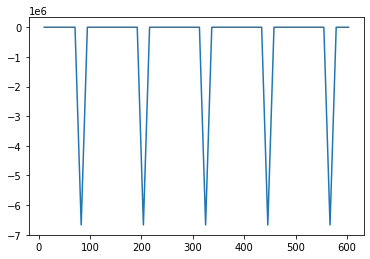

In [13]:
sample = raw[raw["substep"] == 11]
sample["reserves_in"].plot(kind='line')

In [14]:
sample = raw[raw["substep"] == 12]
assert (sample['amm_k'] == 4.900000e+13).all()